### IMPORTING LIBRARIES AND DATA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rasterio import plot
import rasterio
import os

### ML LIBRARIES
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [2]:
#DL LIBRARIES

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.metrics import MeanAbsoluteError, Accuracy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

2023-03-16 01:40:14.923533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
overview = pd.read_csv("overview.csv")

In [4]:
overview

,Unnamed: 0,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
0,0,60,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (1).dcm,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (10).dcm,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,True,APPLIED,../data/50_50_dicom_cases\Contrast\00001 (11).dcm,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (12).dcm,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (13).dcm,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm
...,...,...,...,...,...,...,...,...
95,95,71,False,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,95,ID_0095_AGE_0071_CONTRAST_0_CT.tif,ID_0095_AGE_0071_CONTRAST_0_CT.dcm
96,96,83,False,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,96,ID_0096_AGE_0083_CONTRAST_0_CT.tif,ID_0096_AGE_0083_CONTRAST_0_CT.dcm
97,97,60,False,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,97,ID_0097_AGE_0060_CONTRAST_0_CT.tif,ID_0097_AGE_0060_CONTRAST_0_CT.dcm
98,98,61,False,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,98,ID_0098_AGE_0061_CONTRAST_0_CT.tif,ID_0098_AGE_0061_CONTRAST_0_CT.dcm


In [5]:
overview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      100 non-null    int64 
 1   Age             100 non-null    int64 
 2   Contrast        100 non-null    bool  
 3   ContrastTag     98 non-null     object
 4   raw_input_path  100 non-null    object
 5   id              100 non-null    int64 
 6   tiff_name       100 non-null    object
 7   dicom_name      100 non-null    object
dtypes: bool(1), int64(3), object(4)
memory usage: 5.7+ KB


### DESCRIPTIVE DATA ANALYSIS

We will be doing some basic analysis where we try to understand the dataset and other relevant information about it

we will be doing the following
* distribution of the age
* distribution of the classes
* an image distribution of the dataset

Text(0.5, 1.0, 'Distribution of CT image age')

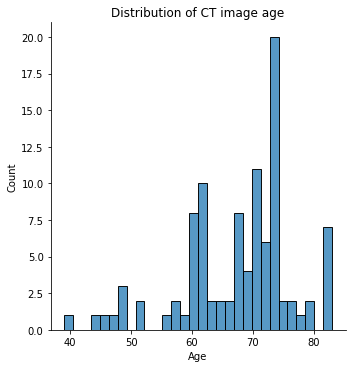

In [6]:
sns.displot(overview["Age"], bins=30)
plt.title("Distribution of CT image age")

In [7]:
labels = []

for file in os.listdir("tiff_images/"):
    labels.append(int(file.split("_")[-2]))

named_labels = []
for x in labels:
    if x == 1:
        named_labels.append("Positive")
    else:
        named_labels.append("Negative")

Text(0.5, 1.0, 'How the labels are separated for 100 selected images')

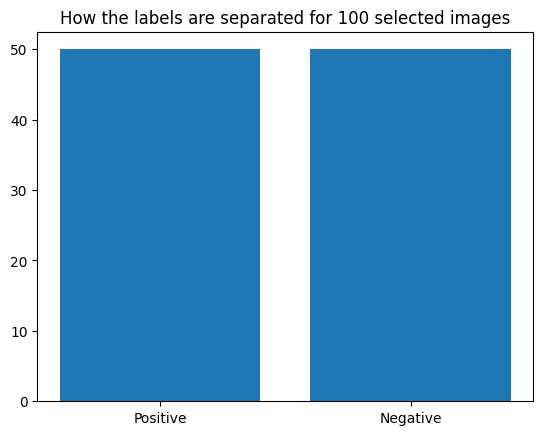

In [8]:
named_labels.count("Positive")

plt.bar(x=["Positive", "Negative"], height=[named_labels.count("Positive"), named_labels.count("Negative")])
plt.title("How the labels are separated for 100 selected images")

In [9]:
import pydicom

parts = []

for f in os.listdir("dicom_dir/"):
    parts.append(pydicom.read_file("dicom_dir/" + f).BodyPartExamined)

Text(0.5, 1.0, 'Which Body Parts was examined?')

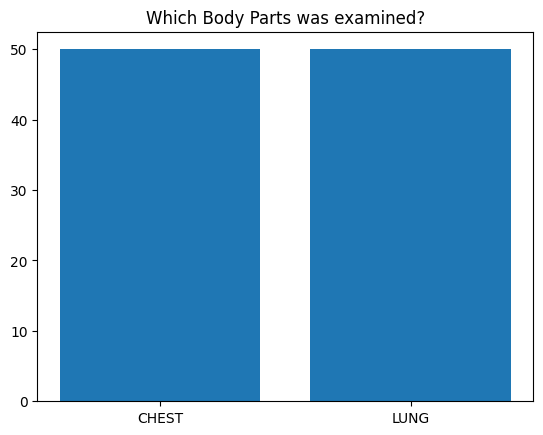

In [10]:
plt.bar(["CHEST", "LUNG"], [parts.count("CHEST"), parts.count("LUNG")])
plt.title("Which Body Parts was examined?")

In [11]:
X = []
#collecting the file name and reading the image files using rasterio
for path in overview["tiff_name"]:
    with rasterio.open(f"tiff_images/{path}") as img:
        arr = img.read()
        arr = arr.reshape((512, 512, 1))
        arr = np.array(arr) / 255
        X.append(arr)

X = np.array(X)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [12]:
new_X = np.array([x.flatten() for x in X])

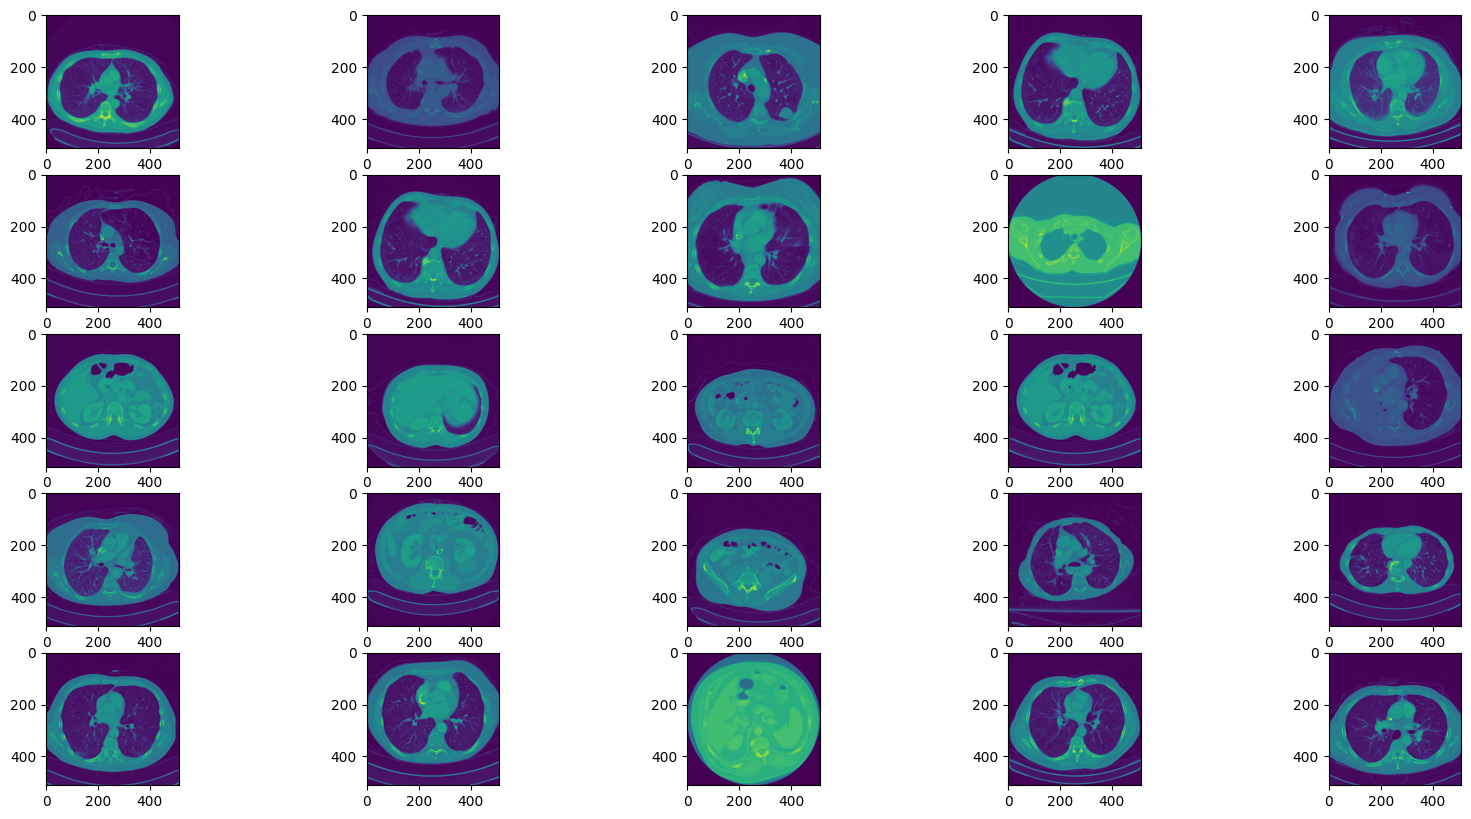

<Figure size 640x480 with 0 Axes>

In [13]:
#plotting of 25 images of CT scans
plt.figure(figsize=(20, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i])
plt.show()
plt.tight_layout()

In [14]:
Y = overview["Age"]

Y = Y / 100

overview["new_age"] = Y

In [15]:
n_labels = np.array(labels)

n_labels.shape

(100,)

In [16]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.3, 1.3]
)

In [17]:
X_T, X_t, y_t, y_te = train_test_split(X, n_labels, test_size=0.2, random_state=42)

In [18]:
#splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [19]:
X_train.shape

(80, 512, 512, 1)

In [20]:

X_T.shape

(80, 512, 512, 1)

In [21]:
#splitting the dataset into training and test sets
X_nt, X_nte, y_nt, y_nte = train_test_split(new_X, n_labels, test_size=0.2,random_state=42)

In [22]:
X_ntt, X_ntte, y_ntt, y_ntte = train_test_split(new_X, Y, test_size=0.2,random_state=42)

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
#scaling of the dataset
sc = StandardScaler()
X_nt_s = sc.fit_transform(X_nt)
X_nte_s = sc.transform(X_nte)

In [25]:
scs = StandardScaler()

X_ntt_s = scs.fit_transform(X_ntt)
X_ntte_s = scs.transform(X_ntte)

## MODEL ARCHITECTURE DEFINITIONS

In [26]:
mlp = MLPClassifier(hidden_layer_sizes=(500, 100), random_state=42, early_stopping=True)

mlp.fit(X_nt_s, y_nt)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(500, 100),
              random_state=42)

In [27]:
mlp.score(X_nte_s, y_nte)

0.8

In [28]:
import pickle
#storing the mlp model in a pickle file
with open("mlp.pkl", "wb") as f:
    pickle.dump(mlp, f)

In [29]:
model = Sequential()
model.add(Conv2D(64, (8, 8), activation = "relu", input_shape = X_train.shape[1:]))
model.add(Conv2D(64, (7, 7), activation = "relu"))
model.add(MaxPooling2D())  #finds the maximun in a matrix and returns it. returns a smaller matrix
model.add(Dropout(0.2)) #randomly removes some part of the data to avoid overfitting
model.add(Conv2D(128, (7, 7), activation = 'relu'))
model.add(MaxPooling2D())
model.add(Flatten()) #turns the mxn matrix into a m*n list
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation="sigmoid"))
model.summary()

2023-03-16 01:42:26.425453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 505, 505, 64)      4160      
                                                                 
 conv2d_1 (Conv2D)           (None, 499, 499, 64)      200768    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 249, 249, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 243, 243, 128)     401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 121, 121, 128)    0         
 2D)                                                    

In [34]:
model.compile(loss = "mean_squared_error", optimizer=Adam(learning_rate=0.001), metrics=MeanAbsoluteError())
#training of the model
batch_size = 5
history = model.fit_generator(
    datagen.flow(X_train,  y_train, batch_size=5),
    epochs=10,
    validation_data=(X_test, y_test)
    )

/var/folders/97/y8rw9vrx0jg_hhwsvq2j449c0000gn/T/ipykernel_5675/1503629920.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
16/16 [==============================] - 498s 31s/step - loss: 0.4599 - mean_absolute_error: 0.6719 - val_loss: 0.4799 - val_mean_absolute_error: 0.6865
Epoch 2/10
16/16 [==============================] - 472s 30s/step - loss: 0.4599 - mean_absolute_error: 0.6719 - val_loss: 0.4799 - val_mean_absolute_error: 0.6865
Epoch 3/10
16/16 [==============================] - 2266s 149s/step - loss: 0.4599 - mean_absolute_error: 0.6719 - val_loss: 0.4799 - val_mean_absolute_error: 0.6865
Epoch 4/10
16/16 [==============================] - 7819s 518s/step - loss: 0.4599 - mean_absolute_error: 0.6719 - val_loss: 0.4799 - val_mean_absolute_error: 0.6865
Epoch 5/10
16/16 [==============================] - 1503s 98s/step - loss: 0.4599 - mean_absolute_error: 0.6719 - val_loss: 0.4799 - val_mean_absolute_error: 0.6865
Epoch 6/10
16/16 [==============================] - 473s 30s/step - loss: 0.4599 - mean_absolute_error: 0.6719 - val_loss: 0.4799 - val_mean_absolute_error: 0.6865
Epoch 7/10


In [31]:
#SAVING THE MODEL INTO A KERAS HDF5 OBJECT FILE

model.save("model.h5")

In [32]:
#storing the training and validation loss in variables for plotting
l1 = history.history['loss']
v1 = history.history['val_loss']

### PLOTTING OF LOSS AND MEAN SQUARED ERROR

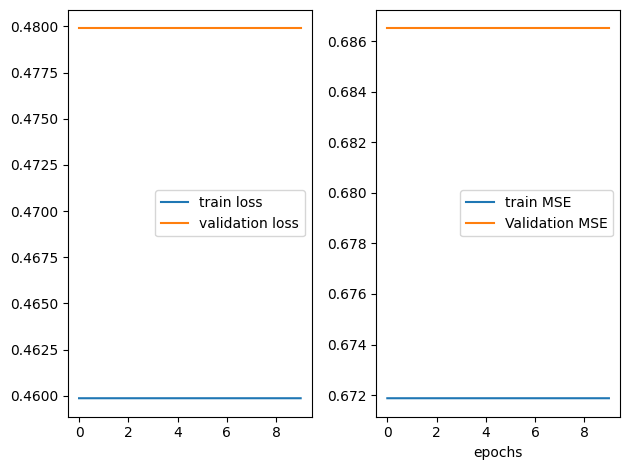

In [39]:
plt.subplot(1,2,1)
plt.plot(list(range(10)), history.history['loss'], label="train loss")
plt.plot(list(range(10)), history.history['val_loss'], label="validation loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(list(range(10)), history.history["mean_absolute_error"], label="train MSE")
plt.plot(list(range(10)), history.history["val_mean_absolute_error"], label="Validation MSE")
plt.xlabel("epochs")
plt.legend()
plt.tight_layout()
